# Segment nuclei and cells

In [1]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.4.0dev


In [2]:
# hard-code the paths of our input and output directories
path_input = "../data/input"
path_output = "../data/output"

# check input images are loaded
stack.check_input_data(path_input)

experiment_1_dapi_fov_1.tif is already in the directory
experiment_1_smfish_fov_1.tif is already in the directory


In this notebook, we show examples of nucleus and cell segmentation. We use 2D projections. Some postprocessing can be applied on the masks to refine the results with a priori informations and constraints.

**Nucleus segmentation** can be performed using:
- A binarization of the dapi channel with a specific threshold.
- A prediction from a U-net based neural network (TODO).

**Cell segmentation** can be performed using:
- A watershed algorithm spread from the nuclei mask.
- A prediction from a U-net based neural network (TODO).

In [3]:
path = os.path.join(path_input, "experiment_1_dapi_fov_1.tif")
nuc = stack.read_image(path)
print("dapi channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype))

path = os.path.join(path_input, "experiment_1_smfish_fov_1.tif")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

dapi channel
 shape: (23, 650, 500)
 dtype: uint16
smfish channel
 shape: (23, 650, 500)
 dtype: uint16


## Nuclei segmentation

### Thresholding

**Thresholding** is performed in three steps:  
- A simple tresholding is applied using `bigfish.segmentation.thresholding` function on a 2D image to obtain a binary mask.  
- The mask is processed with `bigfish.segmentation.clean_segmentation` to remove binary artefacts (small objects, holes).  
- Different nuclei instances are labelled with `bigfish.segmentation.label_instances`.

In [4]:
# 2-d projection
nuc_2d = stack.maximum_projection(nuc)

# thresholding
nuc_mask = segmentation.thresholding(nuc_2d, threshold=27000)
nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=2000, fill_holes=True)
print("nuclei mask")
print("\r shape: {0}".format(nuc_mask.shape))
print("\r dtype: {0}".format(nuc_mask.dtype))

# labeling
nuc_label = segmentation.label_instances(nuc_mask)
print("nuclei labels")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype))

nuclei mask
 shape: (650, 500)
 dtype: bool
nuclei labels
 shape: (650, 500)
 dtype: int64


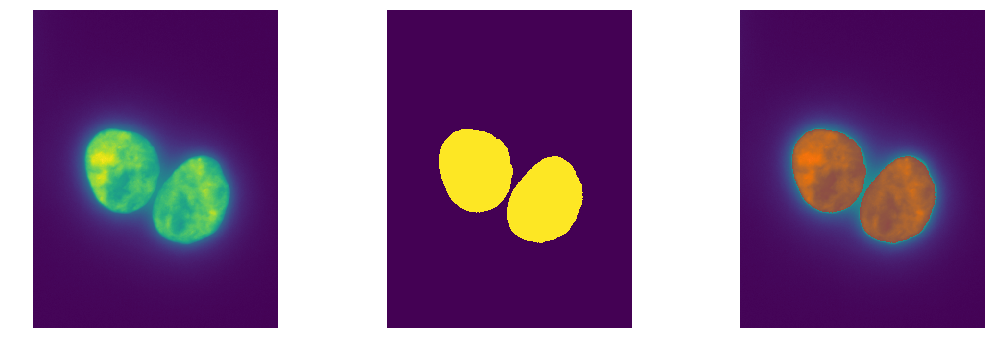

In [5]:
plot.plot_segmentation(nuc_2d, nuc_mask, rescale=True, framesize=(15, 5))

### U-net based model (TODO)

## Cells segmentation

### Watershed

In a **watershed** algorithm (`bigfish.segmentation.cell_watershed`) we consider cells as watershed to be flooded. The **watershed relief** is inversely proportional to both the **pixel intensity** and the **closeness to nuclei**. Pixels with a high intensity or close to labelled nuclei have a low watershed relief value. They will be flooded in priority. Flooding the watersheds allows to propagate nuclei labels through potential cytoplasm areas. The lines separating watershed are the final segmentation of the cells.

In [6]:
cell_label = segmentation.cell_watershed(rna, nuc_label, threshold=4800, alpha=0.9)
print("cells labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

cells labels
 shape: (650, 500)
 dtype: int64


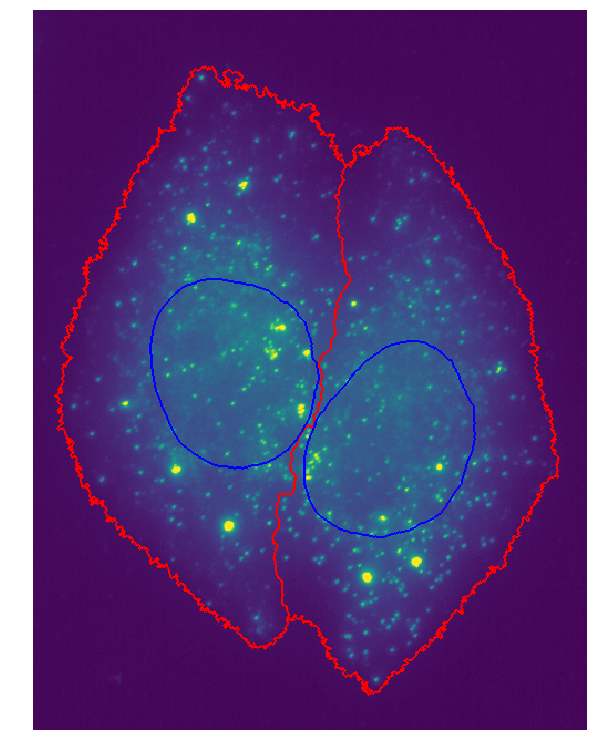

In [7]:
rna_2d = stack.maximum_projection(rna)
plot.plot_segmentation_boundary(rna_2d, cell_label, nuc_label, framesize=(10, 10), contrast=True)

The previous steps can be computed separately. The **watershed algorithm** itself (`bigfish.segmentation.apply_watershed`) needs three elements:
- **Markers** to start the flood (the labelled nuclei).
- A **watershed relief** to drive the flood (`bigfish.segmentation.get_watershed_relief`).
- A **mask** to delimit the flooding area (any binary segmentation of the cells).

In [8]:
# build watershed representation of the cells
watershed_relief = segmentation.get_watershed_relief(rna, nuc_label, alpha=0.9)
print("watershed relief")
print("\r shape: {0}".format(watershed_relief.shape))
print("\r dtype: {0}".format(watershed_relief.dtype))

# build cells mask
cell_mask = segmentation.thresholding(rna_2d, threshold=4800)
cell_mask[nuc_label > 0] = True
cell_mask = segmentation.clean_segmentation(cell_mask, 
                                            small_object_size=5000, 
                                            fill_holes=True)
print("cell mask")
print("\r shape: {0}".format(cell_mask.shape))
print("\r dtype: {0}".format(cell_mask.dtype))

# apply watershed algorithm
cell_label = segmentation.apply_watershed(watershed_relief, nuc_label, cell_mask)
print("cells labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

watershed relief
 shape: (650, 500)
 dtype: uint16
cell mask
 shape: (650, 500)
 dtype: bool
cells labels
 shape: (650, 500)
 dtype: int64


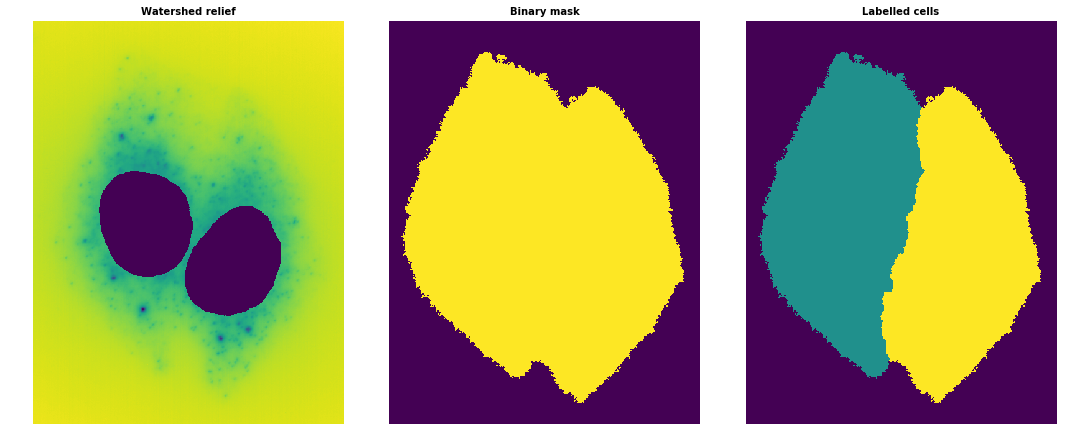

In [9]:
plot.plot_images([watershed_relief, cell_mask, cell_label], 
                 titles=["Watershed relief", "Binary mask", "Labelled cells"], 
                 framesize=(15, 10))

### U-net based model (TODO)

## Post processing

Additional cleaning functions can be applied in the labels with `bigfish.segmentation.clean_segmentation` to smooth the segmented boundaries or properly delimit the different instances.

In [10]:
nuc_label = segmentation.clean_segmentation(nuc_label, delimit_instance=True)
cell_label = segmentation.clean_segmentation(cell_label, smoothness=7, delimit_instance=True)
nuc_label, cell_label = segmentation.match_nuc_cell(nuc_label, cell_label)

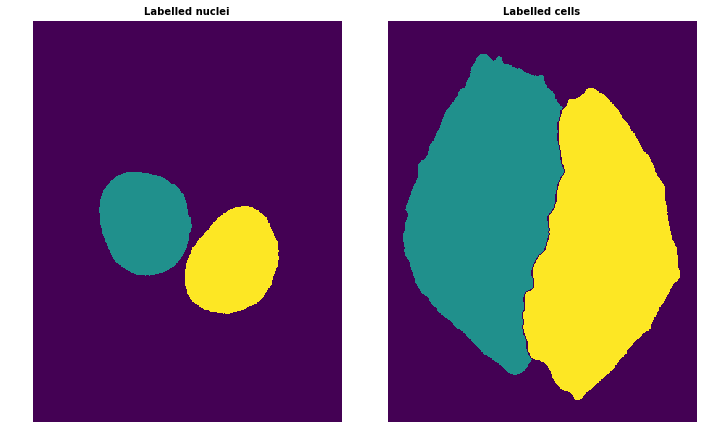

In [11]:
plot.plot_images([nuc_label, cell_label], titles=["Labelled nuclei", "Labelled cells"],
                 framesize=(10, 8))

## Save results

Masks are binary images saved in **png files**. Labelled instances are integer images. A **tif file** should be prefered to ensure dtype consistency. Both methods are possible with `bigfish.stack.save_image`.

In [12]:
# save nuclei and cells labels
path = os.path.join(path_output, "nuc_label.tif")
stack.save_image(nuc_label, path)
path = os.path.join(path_output, "cell_label.tif")
stack.save_image(cell_label, path)